# Multimodal Financial Research Agent with Hybrid Search
Build an intelligent agent that can search financial documents (RAG) and live market data to provide comprehensive insights.

![image.png](attachment:image.png)

## Overview

This notebook covers:
- **Hybrid Search (RAG)**: Semantic + keyword search with automatic filter extraction from historical SEC filings
- **Live Finance Research**: Real-time stock data and market information via Yahoo Finance MCP
- **Agent with Dual Tools**: Connect LLM agent with both vector database and live APIs
- **Financial Analysis**: Query historical SEC filings (10-K, 10-Q) and current market data
- **Metadata Filtering**: Automatic extraction of company, year, quarter from queries

## Setup

In [ ]:
!pip install -U langchain langchain-community sentence-transformers qdrant-client langchain-qdrant fastembed fastembed-gpu langgraph-checkpoint-sqlite langchain-openai langchain-mcp-adapters

In [67]:
import warnings
warnings.filterwarnings('ignore')

In [68]:
# from dotenv import load_dotenv
# load_dotenv()

In [69]:
from langchain_google_genai import ChatGoogleGenerativeAI

from langchain.agents import create_agent

from langchain.messages import HumanMessage, ToolMessage, AIMessage, SystemMessage
from langchain_core.tools import tool

from langgraph.checkpoint.sqlite import SqliteSaver
import sqlite3
from scripts.rag_tools import hybrid_search

In [73]:
results = hybrid_search.invoke({'query': 'what is the revenue of apple in 2024'})

In [74]:
results

[Document(metadata={'company_name': 'apple', 'doc_type': '10-q', 'fiscal_quarter': 'q1', 'fiscal_year': '2024', 'content_type': 'tables', 'file_hash': '835dfa890352f2cb416e48b27a695ffadaf71189c126061305eff6888dcc02ed', 'source_file': 'apple 10-q q1 2024', 'page': 9, '_id': 'e78de28b-9235-4c46-8254-91697f586e9c', '_collection_name': 'financial_docs'}, page_content='**Page:** 9\n\n## Note 2 - Revenue\nNet sales disaggregated by significant products and services for the three- and six-month periods ended March 30, 2024 and April 1, 2023 were as follows (in millions):\n\n|                                 | Three Months Ended   | Three Months Ended   | Six Months Ended   | Six Months Ended   |\n|---------------------------------|----------------------|----------------------|--------------------|--------------------|\n|                                 | March 30, 2024       | April 1, 2023        | March 30, 2024     | April 1, 2023      |\n| iPhone ®                        | $ 45,963       

In [75]:
from scripts.prompts import MULTIMODEL_AGENT_PROMPT
from langchain_openai import ChatOpenAI
from google.colab import userdata


# Initialize the model
model = ChatOpenAI(model="gpt-4o-mini")

## Define Live Finance Research Tool

In [76]:
import subprocess
import sys
import os
from google.colab import userdata

# Get the key from your Colab Secrets
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')


@tool
def live_finance_researcher(query: str):
    """
    Research live stock data using Yahoo Finance MCP.

    Use this tool to get:
    - Current stock prices and real-time market data
    - Latest financial news
    - Stock recommendations and analyst ratings
    - Option chains and expiration dates
    - Recent stock actions (splits, dividends)

    Args:
        query: The financial research question about current market data

    Returns:
        Research results from Yahoo Finance
    """

    code = f"""
import asyncio
from scripts.yahoo_mcp import finance_research
asyncio.run(finance_research("{query}"))
"""
    result = subprocess.run([sys.executable, '-c', code], capture_output=True, text=True)

    return result.stdout

In [77]:
live_finance_researcher.invoke({'query': 'what is the latest stock price of Apple'})

"The latest stock price of **Apple Inc. (AAPL)** is **$255.52**. Here's a summary of the latest trading information:\n\n- **Previous Close**: $258.22\n- **Open**: $257.88\n- **Day's Low**: $254.93\n- **Day's High**: $258.90\n- **Market Cap**: $3.78 trillion\n- **P/E Ratio**: 34.25\n- **Dividend Yield**: 0.41%\n  \n### Additional Insights:\n- **52 Week Low**: $169.21\n- **52 Week High**: $288.62\n- **Volume**: 72,142,773 shares traded\n\nFor further details, you can check [Apple's Investor Relations](http://investor.apple.com/).\n"

## Create Financial Research Agent with Memory

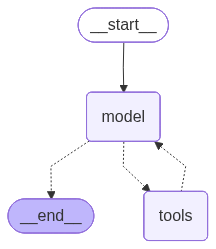

In [78]:
from langgraph.checkpoint.sqlite import SqliteSaver
import sqlite3
from langchain.agents import create_agent

def get_agent():
    conn = sqlite3.connect('data/financial_research_agent.db', check_same_thread=False)
    checkpointer = SqliteSaver(conn=conn)

    agent = create_agent(
        model=model,
        tools=[hybrid_search, live_finance_researcher],
        system_prompt=MULTIMODEL_AGENT_PROMPT,
        checkpointer=checkpointer
    )

    return agent

agent = get_agent()

agent

In [79]:
config = {'configurable': {'thread_id': 'session10'}}

query = 'What is the apples cash flow in 2023?'

agent = get_agent()
response = agent.invoke({'messages': [HumanMessage(query)]}, config=config)

In [80]:
response

{'messages': [HumanMessage(content='What is the apples cash flow in 2023?', additional_kwargs={}, response_metadata={}, id='7b24ae67-72ff-4a0d-85c8-1257400b9759'),
  AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 918, 'total_tokens': 938, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_c4585b5b9c', 'id': 'chatcmpl-CzSWtzGSCMqNEOsw6PuVYFHMcJh6S', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019bd288-5e85-71b2-b2b5-64b79d47bd20-0', tool_calls=[{'name': 'hybrid_search', 'args': {'query': 'Apple cash flow 2023'}, 'id': 'call_Qsb9yfPW0niHAnr19HQeLsht', 'type': 'tool_call'}], invalid_tool_calls=[], usage_metadata=

In [81]:
print(response['messages'][-1].text)

In the fiscal year 2023, Apple Inc. generated significant cash flow, with a detailed breakdown provided in various filings. Below are the key cash flow figures for Apple in 2023:

### Cash Flow Highlights for 2023

1. **Operating Cash Flow**: 
   - For the three months ended December 30, 2023, Apple generated approximately **$39.9 billion** in operating cash flow, an increase when compared to **$34.0 billion** for the same period in the prior year (December 31, 2022).

2. **Investing Activities**: 
   - The company invested in marketable securities with cash generated of **$1.9 billion** from investing activities during the same quarter.

3. **Financing Activities**: 
   - Cash used in financing activities amounted to **$30.6 billion**, which included payments for dividends and share buybacks. 

4. **Ending Cash Balance**: 
   - As of December 30, 2023, Apple reported an ending cash balance of **$41.9 billion**, compared to **$22.0 billion** at the end of the prior year.

### Summary T

## Streaming Helper Function

In [82]:
def stream_agent_response(agent, query, thread_id="default"):

    config = {'configurable': {'thread_id': thread_id}}

    for chunk in agent.stream(
        {'messages': [HumanMessage(query)]},
        stream_mode='messages',
        config=config
    ):
        # Extract message from chunk
        message = chunk[0] if isinstance(chunk, tuple) else chunk

        # Handle AI messages with tool calls
        if isinstance(message, AIMessage) and message.tool_calls:
            for tool_call in message.tool_calls:
                print(f"\n  Tool Called: {tool_call['name']}")
                print(f"   Args: {tool_call['args']}")
                print()

        # Handle tool responses
        elif isinstance(message, ToolMessage):
            print(f"\n  Tool Result (length: {len(message.text)} chars)")
            print()

        # Handle AI text responses
        elif isinstance(message, AIMessage) and message.text:
            # Stream the text content
            print(message.text, end='', flush=True)

## Examples

In [83]:
query = 'What is the apples cash flow in 2023?'
agent = get_agent()

stream_agent_response(agent, query, 'session10')


  Tool Called: hybrid_search
   Args: {}


  Tool Called: 
   Args: {}

{"company_name":"apple","doc_type":null,"fiscal_year":"2023","fiscal_quarter":null}
  Tool Result (length: 23167 chars)

In 2023, Apple Inc.'s cash flow details reflect a strong financial position with robust operating activities. Here are the key figures from the cash flow statements:

### Key Cash Flow Highlights

1. **Operating Cash Flow**:
   - For the year ending September 30, 2023, Apple generated **$139.6 billion** in net cash from operating activities. This is a notable increase compared to the previous year.

2. **Cash Used in Investing Activities**:
   - Cash used in investing activities was **$28.4 billion** for the year, which includes purchases of property, plant, equipment, and marketable securities.

3. **Cash Used in Financing Activities**:
   - Cash used in financing activities totaled **$43.6 billion**, including payments for dividends, stock repurchases, and debt repayments.

4. **Net Change in 

In [84]:
agent = get_agent()
stream_agent_response(agent, "What was Amazon's revenue in Q1 2024?", thread_id="session9")


  Tool Called: hybrid_search
   Args: {}


  Tool Called: 
   Args: {}

{"company_name":"amazon","doc_type":"10-q","fiscal_year":"2024","fiscal_quarter":"q1"}
  Tool Result (length: 25545 chars)

In Q1 2024, Amazon's consolidated net sales were approximately **$143.3 billion**, which marked a **13% increase** compared to Q1 2023. Here’s the breakdown of net sales by segment:

| Segment          | Q1 2023 Revenue (in millions) | Q1 2024 Revenue (in millions) |
|------------------|-------------------------------|-------------------------------|
| North America     | $76,881                       | $86,341                       |
| International     | $29,123                       | $31,935                       |
| AWS               | $21,354                       | $25,037                       |
| **Consolidated**  | **$127,358**                 | **$143,313**                 |

### Key Highlights:
- **North America**: Revenue increased by 12%, from $76.9 billion to $86.3 billion.
- *

In [85]:
agent = get_agent()
stream_agent_response(agent, "What is the current stock price of Apple (AAPL) and show me latest news?",
                      thread_id="session9")


  Tool Called: live_finance_researcher
   Args: {}


  Tool Called: 
   Args: {}


  Tool Called: live_finance_researcher
   Args: {}


  Tool Called: 
   Args: {}


  Tool Result (length: 675 chars)


  Tool Result (length: 1564 chars)

### Current Stock Price of Apple Inc. (AAPL)
- **Current Price:** $255.52
- **Previous Close:** $258.22
- **Opening Price:** $257.88
- **Day's Low:** $254.93
- **Day's High:** $258.90
- **Market Cap:** $3.78 trillion
- **Beta:** 1.09 (indicates volatility compared to the market)
- **Dividend Yield:** 0.41% (Annual dividend rate of $1.04)
- **52-Week Range:** $169.21 - $288.62
- **52-Week Change:** 14.77%
- **Average Analyst Rating:** Buy (2.0 on a scale where 1 is strong buy and 5 is sell)

### Latest News about Apple Inc. (AAPL)
1. **Apple’s AI Roadmap Strengthens With Google Deal, Says Evercore**
   - *Summary*: Evercore ISI analyst Amit Daryanani has reiterated an Outperform rating on Apple stock with a price target of $330. The report emphasizes A

In [86]:
agent = get_agent()
stream_agent_response(agent, "Compare Microsoft's Q2 2024 revenue from filings with its current stock performance",
                      thread_id="session8")


  Tool Called: hybrid_search
   Args: {}


  Tool Called: 
   Args: {}


  Tool Called: live_finance_researcher
   Args: {}


  Tool Called: 
   Args: {}

{"company_name":"microsoft","doc_type":"10-q","fiscal_year":"2024","fiscal_quarter":"q2"}
  Tool Result (length: 0 chars)


  Tool Result (length: 2951 chars)


  Tool Called: hybrid_search
   Args: {}


  Tool Called: 
   Args: {}

{"company_name":"microsoft","doc_type":"10-q","fiscal_year":"2024","fiscal_quarter":"q2"}
  Tool Result (length: 0 chars)

It appears that I couldn't find specific documentation regarding Microsoft's Q2 2024 revenue from SEC filings, suggesting that the information might not be publicly available yet.

However, I have gathered the current stock performance data for Microsoft (MSFT):

### Microsoft Corporation (MSFT) Stock Performance Overview
- **Current Price:** $459.86
- **Market Cap:** $3.42 trillion
- **P/E Ratio (TTM):** 32.68
- **Dividend Rate:** $3.64 (Yield: 0.79%)
- **52-Week Range:** $344.79 - 

In [89]:
agent = get_agent()
stream_agent_response(agent, "Compare Google's revenue between Q2 2024 and Q2 2025",
                      thread_id="session12")


  Tool Called: hybrid_search
   Args: {}


  Tool Called: 
   Args: {}


  Tool Called: hybrid_search
   Args: {}


  Tool Called: 
   Args: {}

{"company{"company_name":"_name":"google","google","doc_type":"10-q","fiscaldoc_type_year":"":"102025","f-q","iscal_qufiscal_year":"2024arter":"","fq2"}iscal_quarter":"q2"}
  Tool Result (length: 27011 chars)


  Tool Result (length: 25095 chars)

Here's a comparison of Google's revenue for Q2 2024 and Q2 2025, based on their 10-Q filings:

### Revenue Comparison

| Revenue Source                                 | Q2 2024 (in millions) | Q2 2025 (in millions) |
|------------------------------------------------|-----------------------|-----------------------|
| Google Search & other                          | $48,509               | $54,190               |
| YouTube Ads                                    | $8,663                | $9,796                |
| Google Network                                  | $7,444                | $7,354         